pythonでGibbs samplingする

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
c_list = sns.color_palette().as_hex()
color_num = len(c_list)

In [3]:
np.random.seed(1)

#　線形基底関数モデル(多項式回帰)

## トイデータ

In [4]:
def polynomial(x, degree):
    return [np.power(x, d) for d in np.arange(0, degree+1)]

def system_model(feature, w):
    y = np.dot(w, feature)
    return y

def observation(x, w, degree=3, var=0.5):
    feature = polynomial(x, degree)
    y = system_model(feature, w)
    z = np.random.normal(loc=y, scale=np.sqrt(var))
    return z

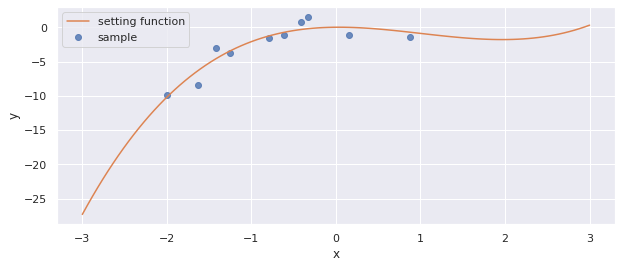

In [5]:
xs = np.linspace(-3, 3, 100)
w_t = [0., 0.1, -1.5, 0.5]
y = system_model(polynomial(xs, len(w_t)-1), w_t)

var_y = (1.0)**2
x_sample = np.random.uniform(low=-2, high=2, size=10)
z = observation(x=x_sample, w=w_t, degree=len(w_t)-1, var=var_y)

fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)
ax.plot(xs, y, color=c_list[1], label="setting function")
ax.scatter(x_sample, z, color=c_list[0], alpha=0.8, label="sample")
ax.legend()
ax.set_xlabel("x");
ax.set_ylabel("y");

## 実装

In [6]:
# wの事前分布のパラメータ
var_w = 1.0

### 解析解

In [7]:
def design_matrix(xs, n_degree):
    return np.array(polynomial(xs, n_degree)).T

In [8]:
%%time
# 解析解
Phi = design_matrix(x_sample, 3)
Sig_hat_inv = var_y * np.dot(Phi.T, Phi) + var_w * np.eye(4)
Sig_hat = np.linalg.inv(Sig_hat_inv)
mu_hat = var_y * np.dot(np.dot(Sig_hat, Phi.T), z)

CPU times: user 15.4 ms, sys: 7.08 ms, total: 22.5 ms
Wall time: 21.7 ms


In [9]:
n_sample = 1000
w_post = np.random.multivariate_normal(mu_hat, Sig_hat, n_sample)

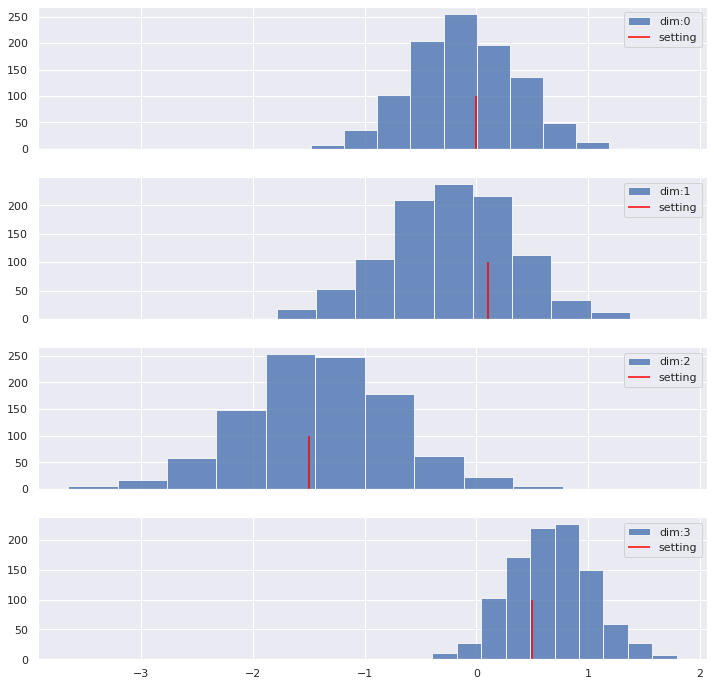

In [10]:
fig = plt.figure(figsize=(12, 3*len(mu_hat)))
ax = fig.subplots(len(mu_hat),1, sharex=True)

for i in range(len(mu_hat)):
    ax[i].hist(w_post[:,i], alpha=0.8, label=f"dim:{i}")
    ax[i].vlines(w_t[i], 0, n_sample/10, color="red", label="setting")
    ax[i].legend()

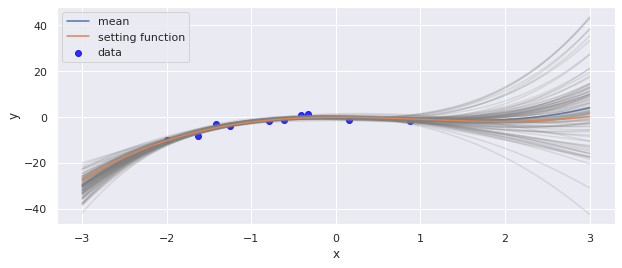

In [11]:
w = mu_hat
y = system_model(polynomial(xs, len(w)-1), w)
y_set = system_model(polynomial(xs, len(w_t)-1), w_t)

fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)
ax.plot(xs, y, color=c_list[0], label="mean")
for i in range(100):
    w_tmp = w_post[i,:]
    y_tmp = system_model(polynomial(xs, len(w_tmp)-1), w_tmp)
    ax.plot(xs, y_tmp, color="gray", alpha=0.2)

ax.scatter(x_sample, z, color="blue", alpha=0.8, label="data")
ax.plot(xs, y_set, color=c_list[1], label="setting function")
ax.legend()
ax.set_xlabel("x");
ax.set_ylabel("y");

### Gibbs sampling

In [12]:
# ギブスサンプリング
n_degree = 3 # モデルの次数

n_sample = 10000
n_burn = 500
w = np.zeros(n_degree+1)
ws = np.zeros((n_sample+1, n_degree+1))
ws[0] = w

In [13]:
design_mat = design_matrix(xs=x_sample, n_degree=n_degree)
design_mat.shape

(10, 4)

In [14]:
def alpha_i(design_mat, w, idx):
    w_not_i = np.delete(w, idx)
    dm_not_i = np.delete(design_mat, idx, 1)
    return np.dot(w_not_i, dm_not_i.T)

In [15]:
%%time
for i in tqdm(np.arange(n_sample)):
    for idx in range(n_degree+1): # wを一つづつサンプル
        sum_phi_2 = np.dot(design_mat[:,idx], design_mat[:,idx])
        inv_var_hat = (1./var_w) + (1./var_y) * sum_phi_2
        var_hat = 1. / inv_var_hat
        
        sum_y_phi = np.dot(z, design_mat[:, idx])
        alpha = alpha_i(design_mat, w, idx)
        sum_a_phi = np.dot(alpha, design_mat[:, idx])
        m_hat = (sum_y_phi - sum_a_phi) * (1./var_y) * var_hat
        
        w[idx] = np.random.normal(m_hat, np.sqrt(var_hat))
    ws[i+1] = w.copy()

100%|██████████| 10000/10000 [00:08<00:00, 1129.12it/s]

CPU times: user 8.99 s, sys: 98.4 ms, total: 9.08 s
Wall time: 8.94 s


In [16]:
ws.shape

(10001, 4)

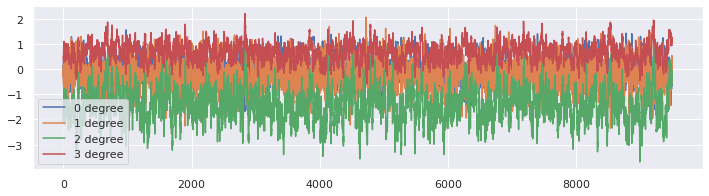

In [17]:
fig = plt.figure(figsize=(12, 3))
ax = fig.subplots(1,1)

for i in np.arange(n_degree+1):
    ax.plot(ws[n_burn:,i], label='{} degree'.format(i))
ax.legend()

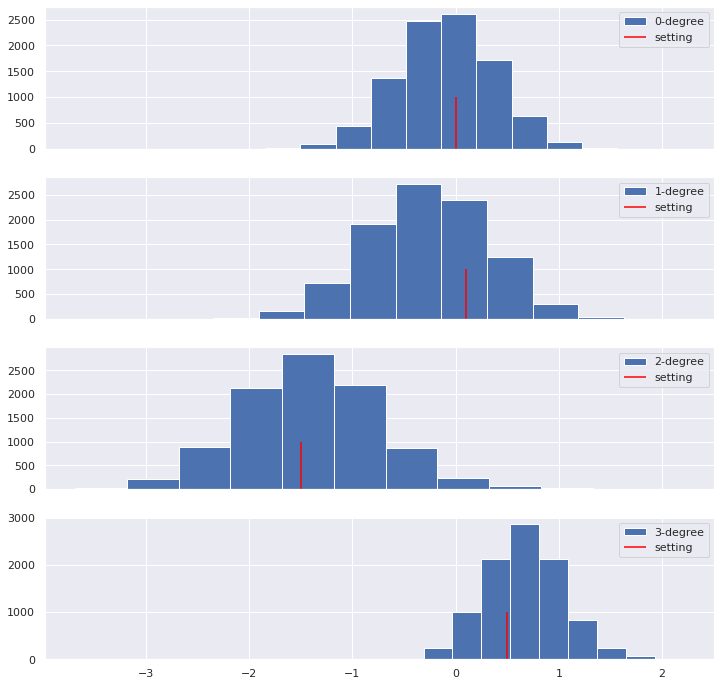

In [18]:
fig = plt.figure(figsize=(12, 3*(n_degree+1)))
ax = fig.subplots((n_degree+1),1, sharex=True)
if n_degree < 1:
    ax = [ax]

for i in range(n_degree+1):
    ax[i].hist(ws[n_burn:,i], label=f'{i}-degree')
    ax[i].vlines(w_t[i], 0, n_sample/10, color="red", label="setting")
    ax[i].legend()

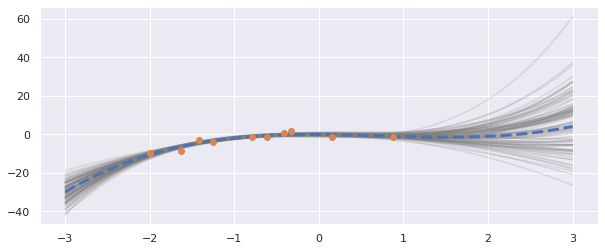

In [19]:
# 事後分布からwをサンプル
rand_idx = np.random.choice(n_sample-n_burn, 100, replace=False) + n_burn
sample_post_ws = ws[rand_idx, :]

fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1,1)

sample_prior = list(map(lambda x:np.dot(sample_post_ws, polynomial(x=x, degree=n_degree)), xs))
ax.plot(xs, sample_prior, '-', c='gray', alpha=0.2)
ax.plot(xs, y, '--', lw=3)
ax.plot(x_sample, z, 'o')